Last updated 2020-02-03

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import shap

from clf_eval_utils import quickplot_eval_3, quickplot_eval_4
from shap_wrappers import dep_plot, get_shap_categories, plot_shap_summary_bar

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load NHFES data

Available for download at https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv

In [2]:
full_data = pd.read_csv(os.path.join('data','nhefs.csv'))
full_data.drop(['seqn','yrdth','modth','dadth'], axis=1, inplace=True)
full_data.dropna(axis=1,inplace=True)
full_data.head()

,qsmk,death,sex,age,race,marital,school,education,ht,wt71,...,allergies,nerves,lackpep,hbpmed,boweltrouble,wtloss,infection,active,exercise,birthcontrol
0,0,0,0,42,1,2,7,1,174.1875,79.04,...,0,0,0,1,0,0,0,0,2,2
1,0,0,0,36,0,2,9,2,159.3750,58.63,...,0,0,0,0,0,0,1,0,0,2
2,0,0,1,56,1,3,11,2,168.5000,56.81,...,0,1,0,0,0,0,0,0,2,0
3,0,1,0,68,1,3,5,1,170.1875,59.42,...,0,0,0,0,0,0,0,1,2,2
4,0,0,0,40,0,2,11,2,181.8750,87.09,...,0,0,0,0,1,0,0,1,1,2


In [3]:
data_desc = pd.read_excel(os.path.join('data','NHEFS_Codebook.xls'))
data_desc_dict = pd.Series(index=data_desc['Variable name'], data=data_desc['Description'].values).to_dict()
data_desc.head()

,Variable name,Description,Category
0,active,"IN YOUR USUAL DAY, HOW ACTIVE ARE YOU? IN 1971...",Lifestyle
1,age,AGE IN 1971,Base features
2,alcoholfreq,HOW OFTEN DO YOU DRINK? IN 1971 0: Almost ev...,Lifestyle
3,alcoholhowmuch,"WHEN YOU DRINK, HOW MUCH DO YOU DRINK? IN 1971",Lifestyle
4,alcoholpy,"HAVE YOU HAD 1 DRINK PAST YEAR? IN 1971, 1:EV...",Lifestyle


In [4]:
data_desc.Category.value_counts()

Diagnoses          16
Socioeconomic      12
Lifestyle          11
Medications        11
Anthropometrics     6
Outcome             4
Base features       3
ID                  1
Name: Category, dtype: int64

# Split train\test

In [5]:
data_train, data_test = train_test_split(full_data, test_size=0.3)
print(f'Train: {data_train.shape}, Test: {data_test.shape}')\

X_train, y_train = data_train.loc[:, data_train.columns!='death'], data_train.loc[:, 'death']
X_test, y_test = data_test.loc[:, data_test.columns!='death'], data_test.loc[:, 'death']

Train: (1140, 44), Test: (489, 44)


# Predict

In [6]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    max_depth=3, random_state=0).fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

print(f'Train AUC: {roc_auc_score(y_train,y_pred_train)}')
print(f'Test AUC: {roc_auc_score(y_test,y_pred_test)}')

Train AUC: 0.8739974924874125
Test AUC: 0.8248971722365038


# Eval

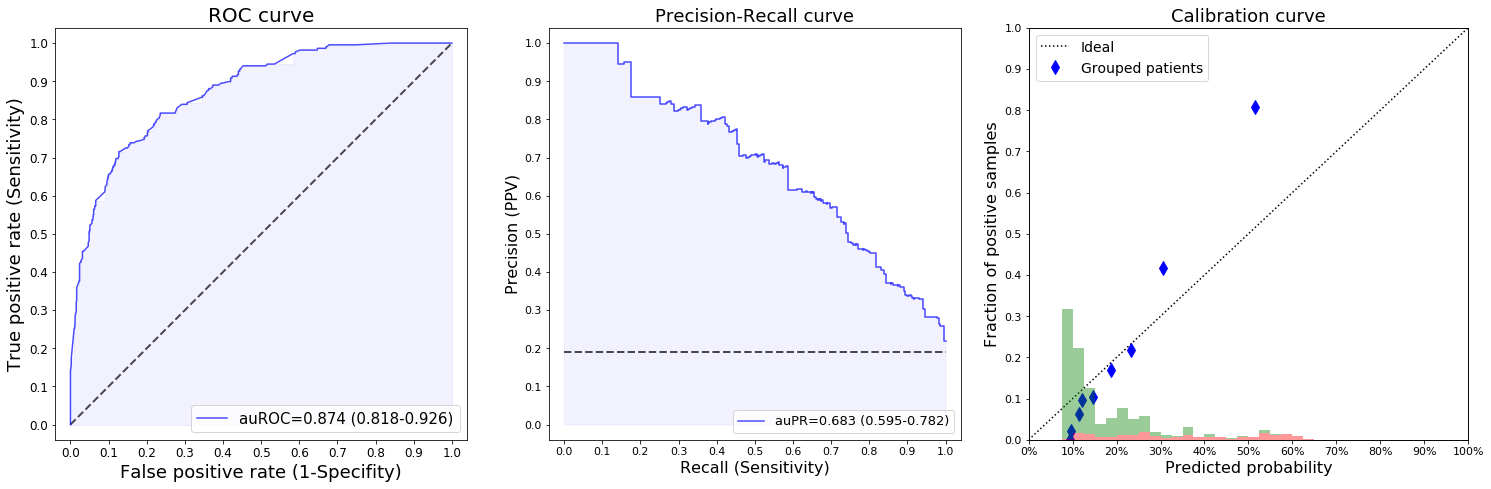

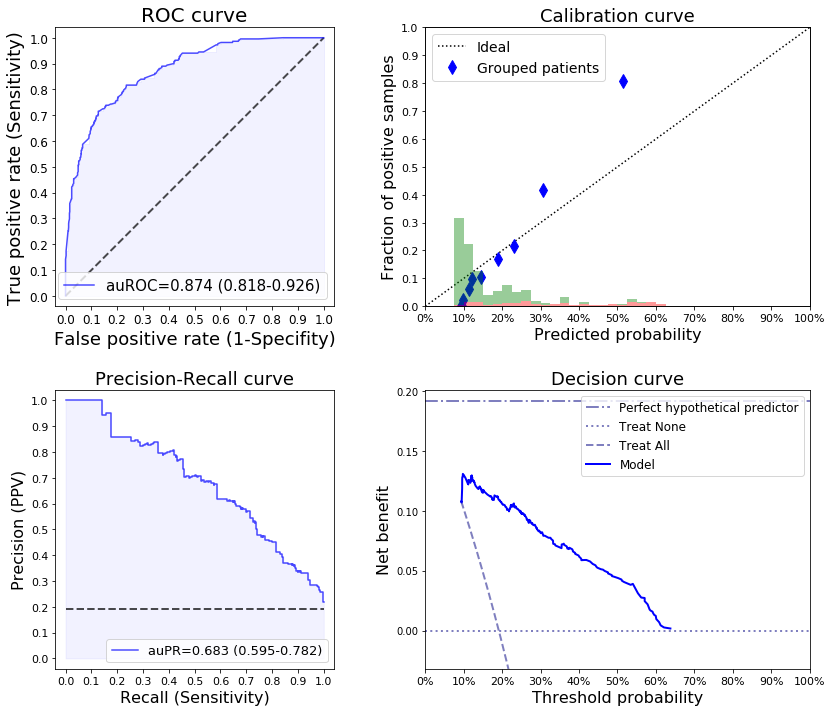

In [7]:
y_true = y_train
y_pred = y_pred_train

quickplot_eval_3(y_true, y_pred)

quickplot_eval_4(y_true, y_pred)

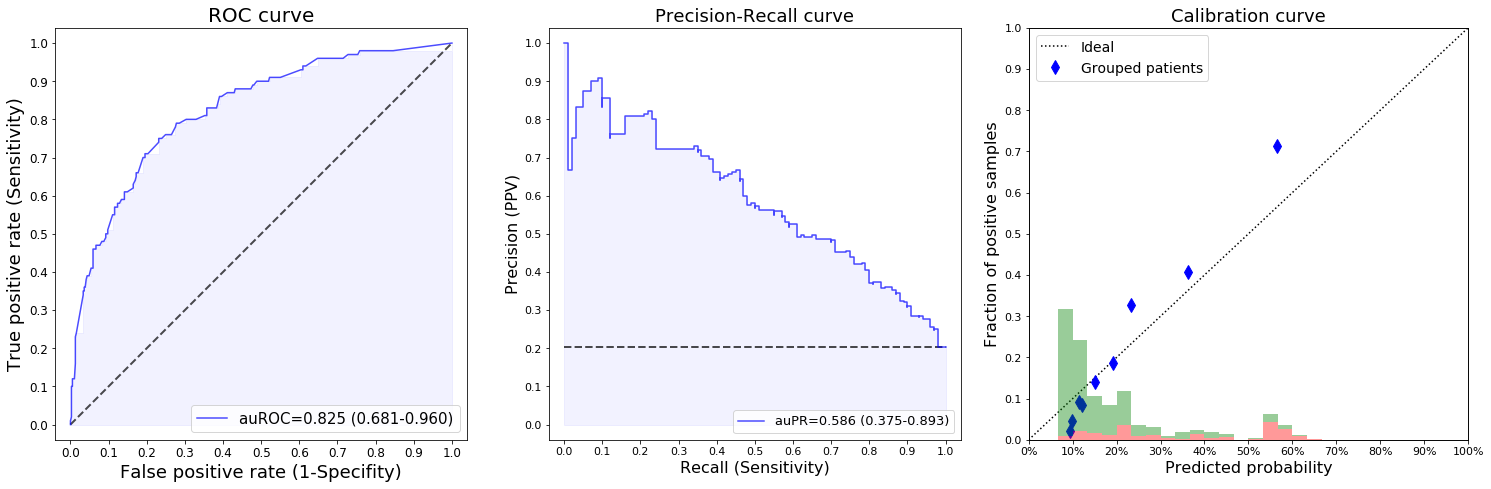

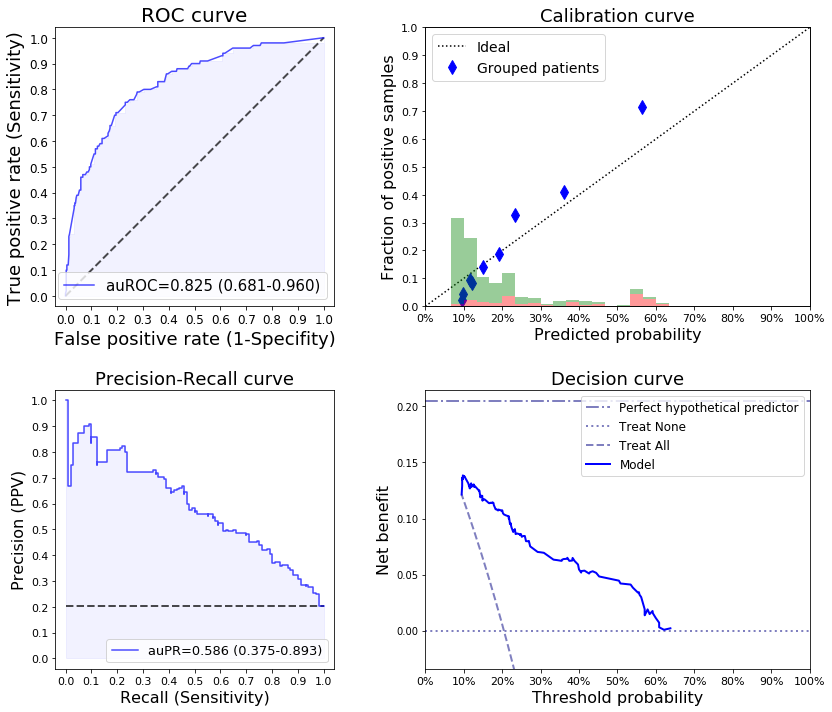

In [8]:
y_true = y_test
y_pred = y_pred_test

quickplot_eval_3(y_true, y_pred)

quickplot_eval_4(y_true, y_pred)

# simple SHAP

In [9]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


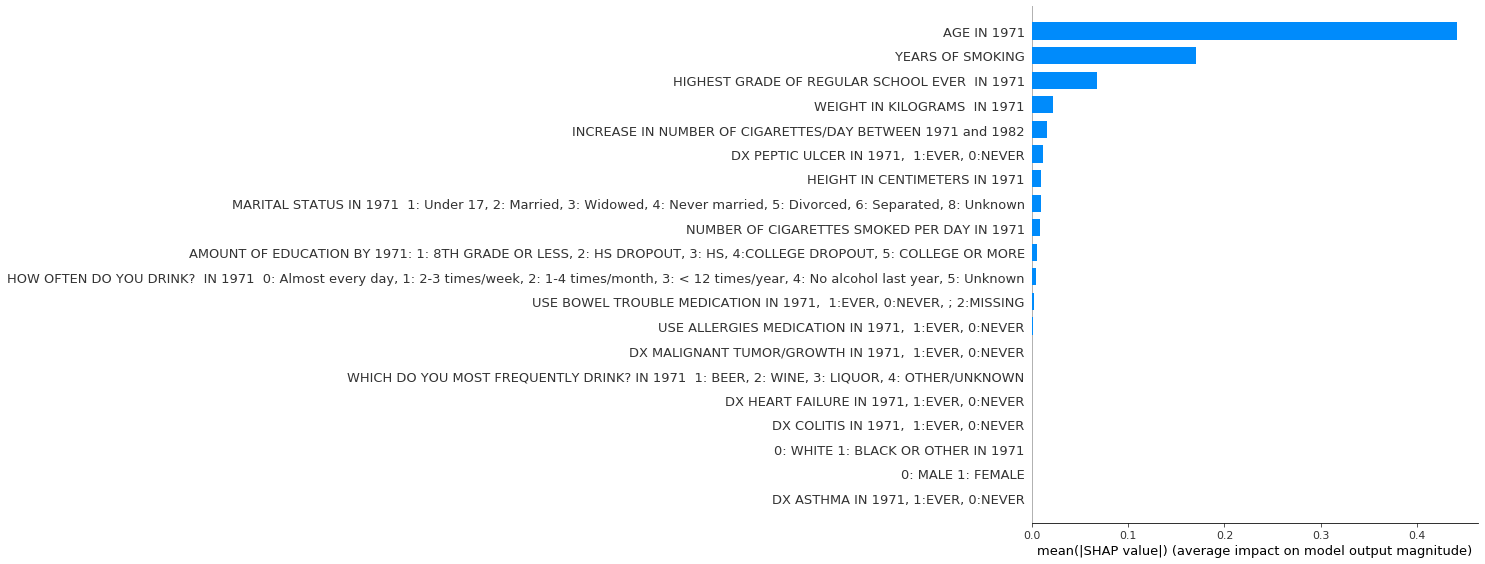

In [10]:
shap.summary_plot(shap_values, X_train.rename(columns=data_desc_dict), plot_type='bar')

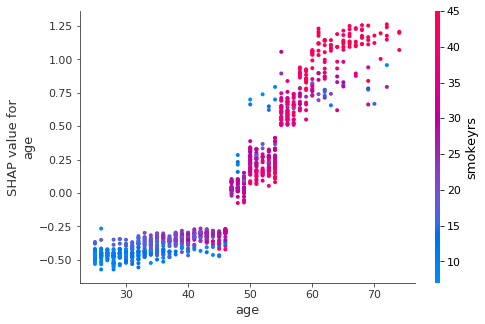

In [11]:
shap.dependence_plot(X_train.columns.get_loc('age'), shap_values, X_train)

# Custom SHAP plots

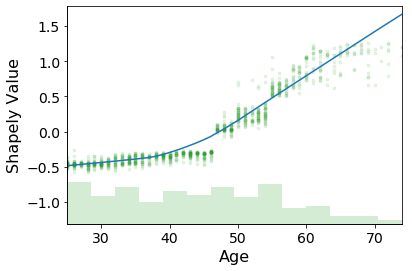

In [12]:
features = X_train
base_shap = explainer.expected_value
feat_text = 'Age'
feature_name = 'age'
shap_columns = None
shap_text = None
manual_bins = None
x_quantile_min = None
x_quantile_max = None
SZ = 16
color = sns.color_palette()[2]

dep_plot(feature_name=feature_name, shap_values=shap_values, features=features, shap_columns=shap_columns, ax=None,
         feature_text=feat_text, shap_text=shap_text,
         base_shap=base_shap, y_transform=None, add_nan=False, nan_label='NaN',
         x_min=None, x_max=None, x_round=None, manual_bins=manual_bins,
         x_quantile_min=x_quantile_min, x_quantile_max=x_quantile_max,
         plot_hist=True, plot_type='lowess',
         SZ=SZ, color=color, hist_color=color)

# Categorical summary plot

In [13]:
shap_cats = get_shap_categories(shap_values=shap_values, features=X_train,
                                features_categories=data_desc, feat_col='Variable name', cat_col='Category')
shap_cats.head()

,Lifestyle,Base features,Medications,Diagnoses,Socioeconomic,Anthropometrics
0,-0.138970,0.020251,0.005907,0.024786,0.116716,-0.016737
1,-0.081075,-0.297731,-0.001525,0.005428,-0.063510,-0.008242
2,-0.047506,0.387691,-0.002675,-0.003984,-0.045684,-0.006463
3,-0.211944,-0.365326,0.000905,-0.004024,-0.064476,-0.006947
4,-0.043681,-0.362699,0.008203,-0.003903,-0.030946,-0.009236


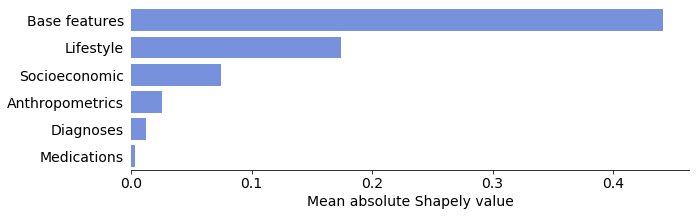

In [14]:
plot_shap_summary_bar(shap_cats, ax=None, sz=14)